# Pre-process

### Virtual Environment: remote_sensing_v2 
### Colour Normalization and Upsampling
### Creates images with enhanced colored normalization

In [7]:
import os
os.chdir('/home/ubuntu/Desktop/DL_WorkSpace/WorkSpace/Input_Data_Container/Bangkok_Province/Commercial_WS/scene_classification_ws')

In [8]:
home_direc = os.getcwd()
print(home_direc)

/home/ubuntu/Desktop/DL_WorkSpace/WorkSpace/Input_Data_Container/Bangkok_Province/Commercial_WS/scene_classification_ws


##### Dictionaries for Colour Normalization

In [9]:
# Pre -processing: stretch, filtering, edge sharpness
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from tqdm.auto import tqdm
import rasterio

# opencv data to gdal
def OpencvData2GdalData(OpencvImg_data):
    GdalImg_data = np.zeros((OpencvImg_data.shape[2],OpencvImg_data.shape[0],OpencvImg_data.shape[1]),np.uint8)
    for i in range(OpencvImg_data.shape[2]):
        # Note that opencv is BGR
        data = OpencvImg_data[:,:,OpencvImg_data.shape[2]-i-1]
        data = np.reshape(data,(OpencvImg_data.shape[0],OpencvImg_data.shape[1]))
        GdalImg_data[i] = data
    return GdalImg_data
    
# gdal data to opencv
def GdalData2OpencvData(GdalImg_data):
    OpencvImg_data = np.zeros((GdalImg_data.shape[1],GdalImg_data.shape[2],GdalImg_data.shape[0]),np.uint8)
    for i in range(GdalImg_data.shape[0]):
        OpencvImg_data[:,:,i] = GdalImg_data[GdalImg_data.shape[0]-i-1,:,:]
    return OpencvImg_data

# read tiff
def readTif(fileName):
    dataset = rasterio.open(fileName)
    if dataset == None:
        print(fileName + "file cannot be opened")
    #  the number of columns of the raster matrix
    width = dataset.width 
    #  The number of rows of the raster matrix
    height = dataset.height
    # image matrix
    data = dataset.read([1, 2, 3])
    #  Get affine matrix information
    geotrans = dataset.transform
    #  Get projection information
    crs = dataset.crs
    return width, height, data, geotrans, crs

# Laplace sharpening
def laplacian_sharpening(img, K_size=3):
    def laplacian_process(img, K_size=3):
        H, W = img.shape
        # zero padding
        pad = K_size // 2
        out = np.zeros((H + pad * 2, W + pad * 2), dtype=float)
        out[pad: pad + H, pad: pad + W] = img.copy().astype(float)
        tmp = out.copy()
        # laplacian kernle
        K = [[0., 1., 0.],[1., -4., 1.], [0., 1., 0.]]
        # filtering and adding image -> Sharpening image
        for y in range(H):
            for x in range(W):
                # core code
                out[pad + y, pad + x] = (-1) * np.sum(K * (tmp[y: y + K_size, x: x + K_size])) + tmp[pad + y, pad + x]
        out = np.clip(out, 0, 255)
        out = out[pad: pad + H, pad: pad + W].astype(np.uint8)
        return out
    b, g, r = cv2.split(img)# split into three bands
    r_p = laplacian_process(r)
    g_p = laplacian_process(g)
    b_p = laplacian_process(b)
    result = cv2.merge((b_p, g_p, r_p))# The three bands after merging
    return np.uint8(result)

# 2%linear stretch
def truncated_linear_stretch(image, truncated_value=2):
    max_out = 255
    min_out = 0
    b, g, r = cv2.split(image)#split into three bands
    def gray_process(gray):
        truncated_down = np.percentile(gray, truncated_value) #Obtain the gray level corresponding to the 98% histogram
        truncated_up = np.percentile(gray, 100 - truncated_value) #in the same way
        gray = (gray - truncated_down) / (truncated_up - truncated_down) * (max_out - min_out) + min_out 
        gray[gray < min_out] = min_out
        gray[gray > max_out] = max_out
        gray = np.uint8(gray)
        return gray
#         truncated_gray = np.clip(gray, a_min=low_value, a_max=high_value) 
#         processed_gray = ((truncated_gray - low_value)/(high_value - low_value)) * (maxout - minout)#linear stretch
#         return processed_gray
    r_p = gray_process(r)
    g_p = gray_process(g)
    b_p = gray_process(b)
    result = cv2.merge((b_p, g_p, r_p))#合并处理后的三个波段
    return np.uint8(result)

# Contrast-limited adaptive histogram equalization
def process_CLAHE(image, clipLimit=1.5):
    # Create a CLAHE object clipLimit limit contrast, tileGridSize block size
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(8, 8))
    
    b, g, r = cv2.split(image)
    b1 = clahe.apply(b)
    g1 = clahe.apply(g)
    r1 = clahe.apply(r)
    # Adaptive Threshold Limiting Contrast    
    dst = cv2.merge([b1,g1,r1])
    return np.uint8(dst)

#save tif file function
def writeTiff(im_data, filename, save_path):
    width, height, data, geotrans, crs = readTif(filename)
    with rasterio.open(save_path,
                       'w',
                       driver='GTiff',
                       height=height,
                       width=width,
                       count=3,
                       dtype=im_data.dtype,
                       crs=crs,
                       transform=geotrans
                       ) as dst:
        dst.write(im_data)
    return

# bilateral filtering
def bilateral_filter(img, d = 6, sigmaColor = 30, sigmaSpace = 30):
    bf_img = cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace)
    return bf_img

#  Pre -processing
def pre_process(filename, savename, stretch=False, hist=True):
    img = cv2.imread(filename)
    if stretch == True:
        img = truncated_linear_stretch(img, truncated_value=2)  # 2% linear stretch
    if hist == True:
        img = process_CLAHE(img)
    img = bilateral_filter(img) # bilateral filtering
#     img = laplacian_sharpening(img)
    img = OpencvData2GdalData(img) # convert data to gdal
    writeTiff(img, filename, savename) # save

# img_path = os.path.join(train_data_path, 'test.tif')
# img_path2 = os.path.join(train_data_path, 'test2.tif')
# pre_process(img_path, img_path2)

##### Applying the code to a single tiff image from the cropped_tiff_with_buildings folder of scene_classification_ws folder

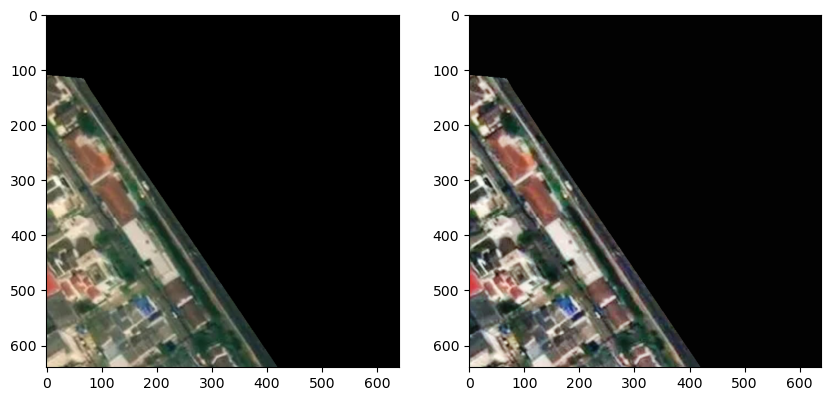

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = '/home/ubuntu/Desktop/DL_WorkSpace/WorkSpace/Input_Data_Container/Bangkok_Province/Commercial_WS/scene_classification_ws/cropped_tiff_with_buildings/Commercial_TIFF_0_41.tif'
img = cv2.imread(img_path)

clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
# Adaptive threshold for restrictions on contrast

b, g, r = cv2.split(img)
b1 = clahe.apply(b)
g1 = clahe.apply(g)
r1 = clahe.apply(r)

dst = cv2.merge([b1,g1,r1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(dst)

##### Applying the code to all the tiff images from the cropped_tiff_with_buildings folder of scene_classification_ws folder and save to new folder

In [11]:
# Creates test_processed direct with enhanced colored normalization of test direct images
# Multi -process test
from multiprocessing import Pool
import os

def img_pre_process(img):
    img_path = os.path.join(data_dir, img)
    save_path = os.path.join(save_dir, img)
    pre_process(img_path, save_path)

#scene_classification_direc = os.path.join(home_direc, 'scene_classification_ws')
colour_normalization_direc = os.path.join(home_direc, 'cropped_tiff_with_cn')

data_dir = os.path.join(home_direc, 'cropped_tiff_with_buildings')
save_dir = colour_normalization_direc
os.makedirs(save_dir, exist_ok=True)

img_list = [f for f in os.listdir(data_dir) if f.endswith('.tif')]
pool = Pool()
pool.map(img_pre_process, img_list) # The key point, IMG_LIST is an iterative object
pool.close()
pool.join()